# Projekt - ceny diamentów

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump,load

# 1. Opis zadania

W poniższym projekcie stworzymy model który będzie wyceniał diament na podstawie różnych jego cechy:
1. carat - waga diamentu podana w karatach
2. cut - jakość szlifu
3. color - kolor diamentu, im bardziej przezroczysty tym lepszy wynik
4. clarity - czystość, dotycząca ilości niedoskonałości wewnątrz diamentu
5. depth - stosunek wysokości diamentu do jego średnicy, wyrażony w procentach
6. table - stosunek górnej powierzchni diamentu do jego średnicy, wyrażony w procentach
7. x,y,z - wymiary diamentu w danej osi, podane w milimetrach

Wykorzystamy do tego 3 typy regresji: K najbliższych sąsiadów, drzewo decyzyjne i las losowy.

# 2. Dane

In [2]:
df = pd.read_csv("dia.csv", sep=",")
df

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


Zaczynamy od wczytania danych i usunięcia pierwszej kolumny zawierającej liczby porządkowe.

In [3]:
df = df.iloc[:,1:]

In [4]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


# 3. Przygotowanie danych

In [5]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

Sprawdzamy typy danych. Część z nich jest typu 'object', więc zamieniamy ja na wartości liczbowe.

In [6]:
#CLARITY: I1 (najgorsza), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (najlepsza)
df["clarity"] = df["clarity"].replace(["IF"],1)
df["clarity"] = df["clarity"].replace(["VVS1"],2)
df["clarity"] = df["clarity"].replace(["VVS2"],3)
df["clarity"] = df["clarity"].replace(["VS1"],4)
df["clarity"] = df["clarity"].replace(["VS2"],5)
df["clarity"] = df["clarity"].replace(["SI1"],6)
df["clarity"] = df["clarity"].replace(["SI2"],7)
df["clarity"] = df["clarity"].replace(["I1"],8)

#color: od J (najgorszy) do D (najlepszy)
df["color"] = df["color"].replace(["D"],1)
df["color"] = df["color"].replace(["E"],2)
df["color"] = df["color"].replace(["F"],3)
df["color"] = df["color"].replace(["G"],4)
df["color"] = df["color"].replace(["H"],5)
df["color"] = df["color"].replace(["I"],6)
df["color"] = df["color"].replace(["J"],7)

#cut: kolejność od najgorszego do najlepszego (Fair, Good, Very Good, Premium, Ideal)
df["cut"] = df["cut"].replace(["Ideal"],1)
df["cut"] = df["cut"].replace(["Premium"],2)
df["cut"] = df["cut"].replace(["Very Good"],3)
df["cut"] = df["cut"].replace(["Good"],4)
df["cut"] = df["cut"].replace(["Fair"],5)

In [7]:
df.dtypes

carat      float64
cut          int64
color        int64
clarity      int64
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

Wszystkie dane maja wartości liczbowe. Następnie sprawdzamy, czy występują puste wartości.

In [8]:
df.isnull().sum(axis=0)

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Nie ma żadnych pustych komórek, więc nie musimy usuwać żadnych wierszy ani kolumn, lub uzupełniać brakujących wartości. Możemy przejść tworzenia modelu.

# 4. Wybór hiperparametrów

In [9]:
#potrzebne importy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Dzielimy zbiór danych na zmienne objaśniające (X) i zmienną objaśnianą (Y).

In [10]:
X = df.drop("price", axis=1)
Y = df["price"]

Dzielimy zbiór danych na dane treningowe i dane testowe.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [12]:
KNN = KNeighborsRegressor()
DT = DecisionTreeRegressor()
RF = RandomForestRegressor()

Wybieramy hiperparametry do testowania i sprawdzamy dla jakich wartości otrzymujemy najlepszy wynik.

### KNN

In [127]:
param_weights_KNN = ["uniform", "distance"]
param_neighbors_KNN = [5,10,15,20,30,50]
param_p_KNN = [1,2,3,4,5,6]

param_KNN = {
    'weights': param_weights_KNN,
    'n_neighbors': param_neighbors_KNN,
    'p' : param_p_KNN}

In [128]:
KNN_gs = GridSearchCV(KNN, param_KNN)
KNN_gs = KNN_gs.fit(X_train, Y_train)

In [129]:
print(KNN_gs.best_params_)
print(KNN_gs.best_score_)

{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.9696651671454404


### DT

In [16]:
param_criterion_DT = ["mse","mae","friedman_mse"]
param_depth_DT = [5,10,20,30]

param_DT = {
    'criterion': param_criterion_DT,
    'max_depth': param_depth_DT,}

In [17]:
DT_gs = GridSearchCV(DT, param_DT)
DT_gs = DT_gs.fit(X_train, Y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'mae', 'friedman_mse'],
                         'max_depth': [5, 10, 20, 30]})

In [18]:
print(DT_gs.best_params_)
print(DT_gs.best_score_)

{'criterion': 'friedman_mse', 'max_depth': 10}
0.9735104124462017


### RF

In [19]:
param_depth_RF = [10,20,30,40,50]
param_estimator_RF = [110,120,130]

param_RF = {
    'max_depth': param_depth_RF,
    'n_estimators': param_estimator_RF}

In [20]:
RF_gs = GridSearchCV(RF, param_RF)
RF_gs = RF_gs.fit(X_train, Y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'n_estimators': [110, 120, 130]})

In [21]:
print(RF_gs.best_params_)
print(RF_gs.best_score_)

{'max_depth': 40, 'n_estimators': 130}
0.98159479132752


In [133]:
#dump(KNN_gs, 'KNN_gs.joblib')
#dump(DT_gs, 'DT_gs.joblib')
#dump(RF_gs, 'RF_gs.joblib')

['RF_gs.joblib']

### Znaleźliśmy najlepsze hiperparametry dla naszych modeli:
1. KNN: weights='distance', n_neighbors=10, p=1
2. DT: criterion = 'friedman_mse', max_depth=10
3. RF: n_estimators=130, max_depth=40

Zobaczmy jak prezentują się wykresy przedstawiające wyniki każdego modelu w zależności od wartości jednego parametru.

In [23]:
score_list_KNN = []
for x in range(1,80):
    KNN = KNeighborsRegressor(n_neighbors=x, weights='distance', p = 1)
    KNN.fit(X_train, Y_train)
    score_list_KNN.append(KNN.score(X_test, Y_test))

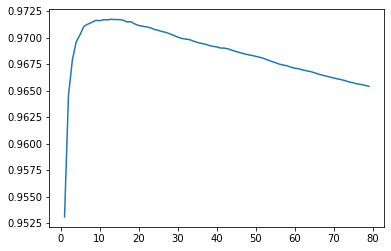

In [24]:
plt.plot(range(1,80),score_list_KNN)

In [25]:
print("liczba sąsiadów =",score_list_KNN.index(max(score_list_KNN))+1)
print("max =", max(score_list_KNN))

liczba sąsiadów = 13
max = 0.9717245546015127


In [125]:
score_list_KNN[:18]

[0.9530754171794019,
 0.9645058062785057,
 0.9678709113500386,
 0.9695981472602814,
 0.9702893000914822,
 0.9710715380109727,
 0.971265975775497,
 0.9714307616593506,
 0.9716208372745854,
 0.9715845496671703,
 0.9716857581697557,
 0.9716702593660244,
 0.9717245546015127,
 0.9716926593480596,
 0.9716935434525249,
 0.9716408011437024,
 0.971469398957283,
 0.9714922125254417]

Dla K najbliższych sąsiadów zrobiliśmy funkcję zależną od liczby sąsiadów. Widać, że na początku funkcja rośnie, a od dla argumentów z przedziału [8,15] utrzymuje się na podobnym poziomie, osiągając maksimum dla 13 sąsiadów. Następnie zaczyna maleć, aż do końca. Zatem przyjmijmy dla naszego modelu wartość hiperparametru n_neighbors=13.

In [26]:
score_list_DT = []
for x in range(1,70):
    DT = DecisionTreeRegressor(criterion = 'friedman_mse', max_depth=x)
    DT.fit(X_train, Y_train)
    score_list_DT.append(DT.score(X_test, Y_test))

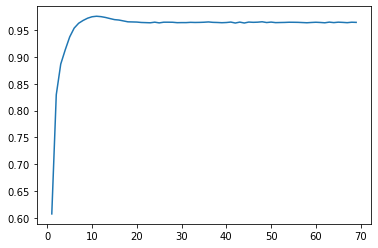

In [27]:
plt.plot(range(1,70),score_list_DT)

In [28]:
print("liczba sąsiadów =", score_list_DT.index(max(score_list_DT)))
max(score_list_DT)

liczba sąsiadów = 10


0.9753386163813451

Dla drzewa decyzyjnego jako argument funkcji wzieliśmy maksymalną głębokość drzewa. Podobnie jak dla K najbliższych sąsiadów, na początku funkcja rośnie, aż osiąga maksimum dla głębokości drzewa równej 10. Później delikatnie maleje, po czym dla argumentów większych od 20 utrzymuje się na stałym poziomie. Więc dla naszego modelu najlepiej przyjąć max_depth=10.

In [29]:
score_list_RF = []
for x in range(1,200):
    RF = RandomForestRegressor(n_estimators=x, max_depth=40)
    RF.fit(X_train, Y_train)
    score_list_RF.append(RF.score(X_test, Y_test))

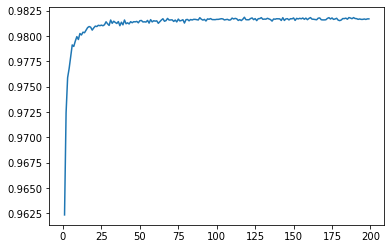

In [30]:
plt.plot(range(1,200),score_list_RF)

In [31]:
print(score_list_RF.index(max(score_list_RF)))
print(max(score_list_RF))

117
0.9818428255696716


In [32]:
max(score_list_RF[100:])-min(score_list_RF[100:])

0.0003784371698770661

Dla lasu losowego wartość funkcji rośnie wraz ze wzrostem liczby drzew. Od około 100 drzew utrzymuje się na stałym poziomie, wahając się o maksymalnie 0.0004. Zatem ustalmy parametr n_estimators=150.

In [34]:
KNN = KNeighborsRegressor(n_neighbors=13, weights='distance', p=1)
KNN = KNN.fit(X_train, Y_train)

In [35]:
DT = DecisionTreeRegressor(criterion = 'friedman_mse', max_depth=10)
DT = DT.fit(X_train, Y_train)

In [36]:
RF = RandomForestRegressor(n_estimators=150, max_depth=40)
RF = RF.fit(X_train, Y_train)

Zapisanie wyników

In [126]:
#dump(RF, 'RandomForest.joblib')
#dump(KNN, 'KNeigbors.joblib')
#dump(DT, 'DecisionTree.joblib')
#dump(score_list_KNN, 'score_list_KNN.joblib')
#dump(score_list_DT, 'score_list_DT.joblib')
#dump(score_list_RF, 'score_list_RF.joblib')

['score_list_RF.joblib']

# 5. Metryki

In [107]:
from sklearn.metrics import explained_variance_score, max_error, mean_squared_error, mean_absolute_error, r2_score

Dla wybranych hiperparametrów sprawdźmy jak wyglądają różne metryki, aby wybrać najlepszy model.

In [38]:
KNN_pred = KNN.predict(X_test)
DT_pred = DT.predict(X_test)
RF_pred = RF.predict(X_test)

In [39]:
models = np.array(['KNN', 'DT', 'RF'])

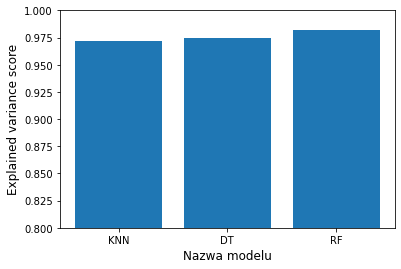

KNN: 0.9717352252076714
DT: 0.974280952615292
RF: 0.9818129489029388


In [40]:
expl_score = np.array([explained_variance_score(Y_test, KNN_pred),
                       explained_variance_score(Y_test, DT_pred),
                       explained_variance_score(Y_test, RF_pred)])

plt.bar(models,expl_score)
plt.ylabel('Explained variance score', fontsize=12)
plt.xlabel('Nazwa modelu', fontsize=12)
plt.ylim([0.8,1.0])
plt.show()

print("KNN:", explained_variance_score(Y_test, KNN_pred))
print("DT:", explained_variance_score(Y_test, DT_pred))
print("RF:", explained_variance_score(Y_test, RF_pred))

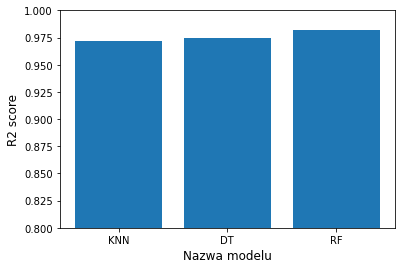

KNN: 0.9717245546015127
DT: 0.9742805634195197
RF: 0.9818129423607675


In [109]:
R2_score = np.array([r2_score(Y_test, KNN_pred),
                       r2_score(Y_test, DT_pred),
                       r2_score(Y_test, RF_pred)])

plt.bar(models,R2_score)
plt.ylabel('R2 score', fontsize=12)
plt.xlabel('Nazwa modelu', fontsize=12)
plt.ylim([0.8,1.0])
plt.show()

print("KNN:", r2_score(Y_test, KNN_pred))
print("DT:", r2_score(Y_test, DT_pred))
print("RF:", r2_score(Y_test, RF_pred))

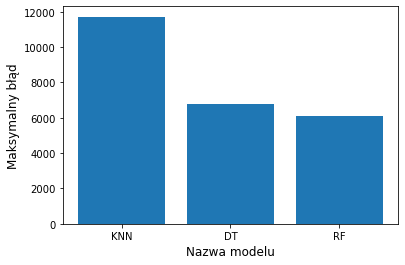

KNN: 11718.661102495958
DT: 6756.0
RF: 6102.093333333334


In [41]:
max_err = np.array([max_error(Y_test, KNN_pred),
                    max_error(Y_test, DT_pred),
                    max_error(Y_test, RF_pred)])

plt.bar(models,max_err)
plt.ylabel('Maksymalny błąd', fontsize=12)
plt.xlabel('Nazwa modelu', fontsize=12)
plt.show()

print("KNN:", max_error(Y_test, KNN_pred))
print("DT:", max_error(Y_test, DT_pred))
print("RF:", max_error(Y_test, RF_pred))

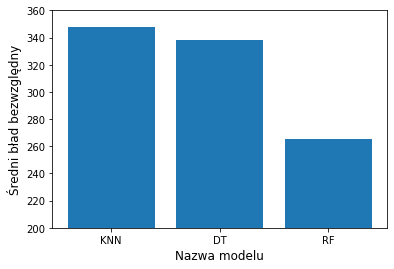

KNN: 347.46199709957887
DT: 338.3435517609351
RF: 265.6453861479931


In [42]:
abs_err = np.array([mean_absolute_error(Y_test, KNN_pred),
                       mean_absolute_error(Y_test, DT_pred),
                       mean_absolute_error(Y_test, RF_pred)])

plt.bar(models,abs_err)
plt.ylabel('Średni bład bezwzględny', fontsize=12)
plt.xlabel('Nazwa modelu', fontsize=12)
plt.ylim([200,360])
plt.show()

print("KNN:", mean_absolute_error(Y_test, KNN_pred))
print("DT:", mean_absolute_error(Y_test, DT_pred))
print("RF:", mean_absolute_error(Y_test, RF_pred))

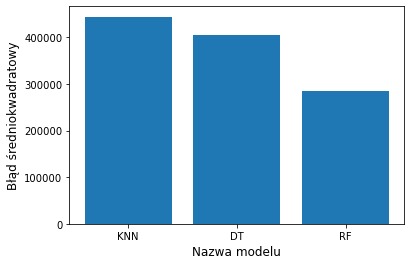

KNN: 444371.9567553627
DT: 404202.16901428264
RF: 285824.6183878204


In [43]:
sqr_err = np.array([mean_squared_error(Y_test, KNN_pred),
                    mean_squared_error(Y_test, DT_pred),
                    mean_squared_error(Y_test, RF_pred)])

plt.bar(models,sqr_err)
plt.ylabel('Błąd średniokwadratowy', fontsize=12)
plt.xlabel('Nazwa modelu', fontsize=12)
plt.show()

print("KNN:", mean_squared_error(Y_test, KNN_pred))
print("DT:", mean_squared_error(Y_test, DT_pred))
print("RF:", mean_squared_error(Y_test, RF_pred))

We wszystkich sprawdzonych metrykach las losowy osiąga najlepsze wyniki. Różnice w explained variance score i r2 score sa niewielkie dla wszysktich modeli. Przewagę lasu losowego nad K najbliższych sąsiadów widać już w maksymalnym błędzie, który jest prawie dwa razy mniejszy.  Średni błąd, mimo że wynosi 265 dla lasu losowego, to i tak jest to ponad 70 mniejszy niz dla dwóch pozostałych modeli, więc najlpeszym modelem jest las losowy.

## 6.Feature Importance, SHAP

In [44]:
print(RF.feature_importances_)

[0.61625971 0.00179765 0.03153865 0.0633981  0.00307438 0.00238537
 0.00449805 0.27207283 0.00497524]


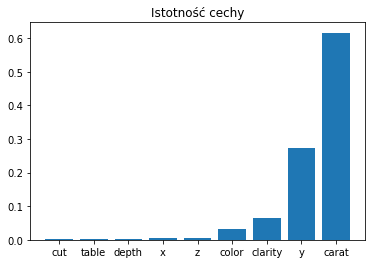

In [117]:
importances = RF.feature_importances_
indices = np.argsort(importances)
feature = X_train.columns

plt.title("Istotność cech")
plt.bar(feature[indices], importances[indices])
plt.show()

In [46]:
import shap

In [47]:
explainer = shap.TreeExplainer(RF)

In [116]:
#shap_values = explainer.shap_values(X_train)
shap_values = load('ShapValues.joblib')

In [90]:
#dump(shap_values,'ShapValues.joblib')

In [114]:
shap_values

array([[-7.22992732e+02, -3.03817096e+01,  1.36149770e+02, ...,
         9.20752676e+01, -7.36678104e+01, -6.63495658e+01],
       [-2.52594111e+03, -4.42266611e+01,  1.60501757e+02, ...,
        -3.13533986e-01, -8.89997020e+02, -8.77185471e+01],
       [-2.40515959e+03, -1.17470885e+01,  1.51025937e+02, ...,
         4.85933196e+01, -8.54928002e+02, -7.34238192e+01],
       ...,
       [-2.94245306e+03,  4.60469694e+01,  2.04284135e+02, ...,
        -1.00834026e+02, -9.55541557e+02, -7.41651311e+01],
       [ 2.15813703e+03,  6.38846725e+01, -1.66495217e+03, ...,
         5.33524820e+01, -9.20530142e+02, -1.33484506e+02],
       [-2.58650133e+03, -4.86708064e+01,  2.10921508e+02, ...,
         4.26690141e+01, -9.58323871e+02, -5.55924070e+01]])

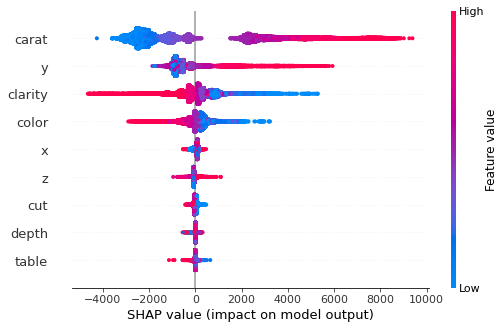

In [112]:
shap.summary_plot(shap_values,X_train)

Z wykresu istotności cech widać, że najważniejsza własność to waga diamentu, a druga istotna cecha to wysokość. Następnie czystość i kolor mają mniejszy wpływ na cenę. Pozostałe cechy diamentu mają marginalny wpływ na cenę.

Patrząc na wykres wartości SHAP widzimy podobne zależności. Tak jak można się spodziewać, im większa waga tym większa cena diamentu, podobnie dla wysokości. W obu przypadkach małe wartośći tylko trochę zaniżają wartość. Dla czystości tylko wartości skrajne mają duzy wpływ na cenę. Podobnie sprawa wygląda dla koloru, ale wpływ na cenę jest tutaj mniejszy.

# Recomendation

Patrząc na powyższe wyniki, najistotniejsze jest podabnie dokładnej wagi i wyskości diamentu, oraz odpowiednie sklasyfikowanie czystości i koloru. Jednak nadanie odpowiednich wartości nie jest takie proste jak zważenie diamentu, ponieważ nie ma jasno określonych wytycznych. Więc najlepiej byłoby wprowadzić unormowany sposób oceny czystości i koloru, aby polepszyć wyniki.